### Inferential Statistics
In this section, I will analysis data using inferntial statistics. I will build statistical significance using hypothesis testing. For all statistical analysis, the level of signifiance will be 1%.

In [98]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import numpy as np
import scipy.stats as st
from sklearn.feature_extraction.text import CountVectorizer
from IPython.core.display import Image, display
from IPython.core.display import HTML
from statsmodels.tsa.stattools import adfuller
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

In [99]:
%store -r calls_for_violent_crimes
%store -r calls_for_property_crimes

### Checking Stationarity

In the following block of code we will test the stationarity of the data using the dickey-fuller test. We will also plot the graph of the time series data with the rolling mean and the rolling standard deviation.

In [100]:
def stationarity_test(timeseries,values):
    
    #Determing the rolling statistics for a month for the data 
    rollingmean = timeseries.rolling(window=30,center=True).mean()
    rollingstd = timeseries.rolling(window=30,center=True).std()
    
    #Plotting the rolling statistics
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rollingmean, color='red', label='Rolling Mean')
    std = plt.plot(rollingstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation for the Time Series')
    plt.show(block=True)
    
    #Performing the Dickey-Fuller test:
    print('Results of the Dickey-Fuller Test:')
    calls_for_service_test = adfuller(values, autolag='AIC')
    calls_for_service_output = pd.Series(calls_for_service_test[0:4], index=['Test Statistics','p-value','No. of Lags Used','Number of Observations Used'])
    for key,value in calls_for_service_test[4].items():
        calls_for_service_output['Critical Value (%s)'%key] = value
    print(calls_for_service_output)
    

# The Dickey Fuller test code has been referenced from https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/

In [101]:
calls_for_violent_crimes['Date'] = calls_for_violent_crimes['call_dttm'].dt.date
calls_for_property_crimes['Date'] = calls_for_property_crimes['call_dttm'].dt.date

In [102]:
groupsv = calls_for_violent_crimes.groupby(['Date']).agg('count')
groupsp = calls_for_property_crimes.groupby(['Date']).agg('count')
groups1= groupsv[['event']]
groups2= groupsp[['event']]

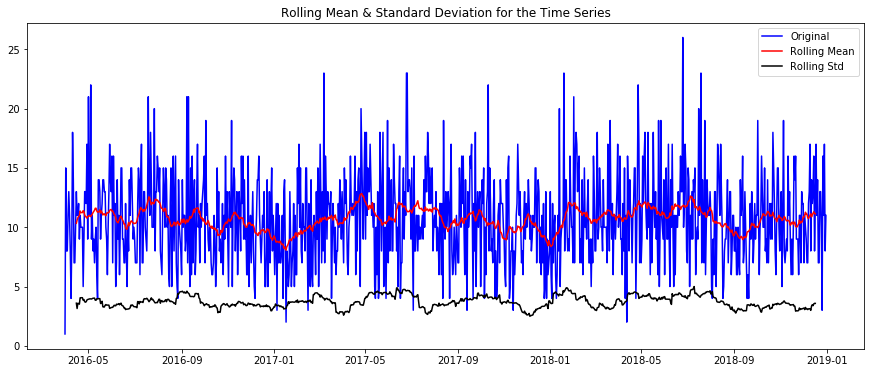

Results of the Dickey-Fuller Test:
Test Statistics               -1.607846e+01
p-value                        5.410928e-29
No. of Lags Used               2.000000e+00
Number of Observations Used    1.003000e+03
Critical Value (1%)           -3.436887e+00
Critical Value (5%)           -2.864426e+00
Critical Value (10%)          -2.568307e+00
dtype: float64


In [103]:
stationarity_test(groups1,groups1.event)

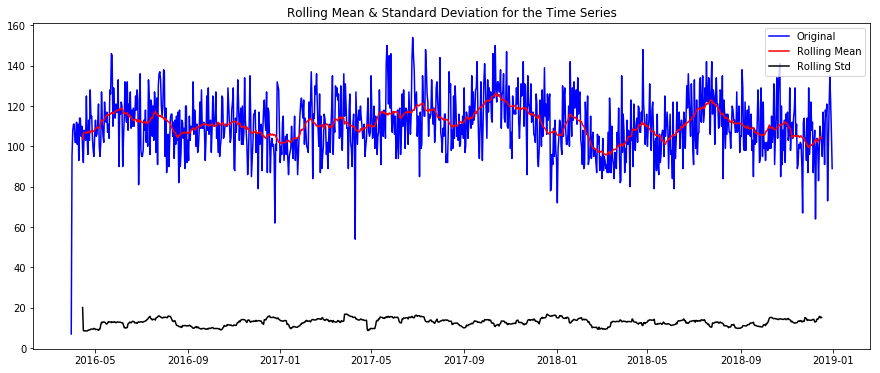

Results of the Dickey-Fuller Test:
Test Statistics               -7.422053e+00
p-value                        6.696389e-11
No. of Lags Used               6.000000e+00
Number of Observations Used    9.990000e+02
Critical Value (1%)           -3.436913e+00
Critical Value (5%)           -2.864437e+00
Critical Value (10%)          -2.568313e+00
dtype: float64


In [104]:
stationarity_test(groups2,groups2.event)

The p-values 5.410928e-29 and 6.696389e-11 proves that there is a trend and seasonality in the data and it is not stationary.

Now we know that there is a trend and seasonality in data, let's make some hypothesis and test them.

### Property crime calls hypothesis

As per the Crime report, Burglary was the only property crime to increase last year in San Francisco, so  let's start with below hypothesis relating calls reporting burglaries.

#### More calls reporting burglary takes place in Summer (June - August) compared to winter (December - February) The increase in burglary is attributable to an increased opportunity for burglars to offend in the late night due to the extended hours of time people are out and homes are left empty.

To test this hypothesis, first test the null hypothesis that the number of calls for burglary in winter are same as in summer.  

In [5]:
calls_for_burglary = calls_for_property_crimes[calls_for_property_crimes['original_crimetype_name'] == 'Burglary']
month = calls_for_burglary.call_dttm.dt.month

In [9]:
# Find the winter and summer subset and replace the data by 1 or 0
calls_for_burglary_winter =  (month <= 2) | (month  == 12)
#calls_for_burglary_winter = (month >= 3) & (month <= 5)
calls_for_burglary_summer = (month >= 6) & (month <= 8)
print(calls_for_burglary_winter.value_counts())
print(calls_for_burglary_summer.value_counts())

False    13564
True      3490
Name: call_dttm, dtype: int64
False    12393
True      4661
Name: call_dttm, dtype: int64


In [7]:
winter = month.where(calls_for_burglary_winter, 0)
winter = winter.where(~calls_for_burglary_winter, 1)
summer = month.where(calls_for_burglary_summer, 0)
summer = summer.where(~calls_for_burglary_summer, 1)

In [8]:
t_value, p_value = st.ttest_ind_from_stats(mean1 = winter.mean(), std1 = winter.std(), nobs1 = winter.count(),
                                           mean2 = summer.mean(), std2 = summer.std(), nobs2 = summer.count())

print('Total # of Violations in winter', winter.mean()*winter.count())
print('Total # of Violations in summer', summer.mean()*summer.count())

print('p-value: ', p_value)
print('t_value: ', t_value)

Total # of Violations in winter 3490.0
Total # of Violations in summer 4661.0
p-value:  3.735964927553748e-50
t_value:  -14.915970856228409


The p-value is less than level of significance 1, so we reject the null hypothesis.

### More calls reporting burglary takes place in Spring (March - May) compared to Summer (June - August) The increase in burglary is attributable to an increased opportunity for burglars to offend in the late night due to the extended hours of time people are out and homes are left empty.

In [13]:
# Find the winter and summer subset and replace the data by 1 or 0
#calls_for_burglary_winter =  (month <= 2) | (month  == 12)
calls_for_burglary_spring = (month >= 3) & (month <= 5)
calls_for_burglary_summer = (month >= 6) & (month <= 8)
print(calls_for_burglary_spring.value_counts())
print(calls_for_burglary_summer.value_counts())

False    12839
True      4215
Name: call_dttm, dtype: int64
False    12393
True      4661
Name: call_dttm, dtype: int64


In [15]:
spring = month.where(calls_for_burglary_spring, 0)
spring = spring.where(~calls_for_burglary_spring, 1)
summer = month.where(calls_for_burglary_summer, 0)
summer = summer.where(~calls_for_burglary_summer, 1)

t_value, p_value = st.ttest_ind_from_stats(mean1 = spring.mean(), std1 = spring.std(), nobs1 = spring.count(),
                                           mean2 = summer.mean(), std2 = summer.std(), nobs2 = summer.count())

print('Total # of Violations in spring', spring.mean()*spring.count())
print('Total # of Violations in summer', summer.mean()*summer.count())

print('p-value: ', p_value)
print('t_value: ', t_value)

Total # of Violations in spring 4215.0
Total # of Violations in summer 4661.0
p-value:  3.6912232284393345e-08
t_value:  -5.5062854174813465


The p-value is less than level of significance 1, so we reject the null hypothesis.

### More calls reporting violent crimes takes place in Spring (March - May) compared to Summer (June - August)

In [118]:
# Find the spring and summer subset and replace the data by 1 or 0
#calls_for_burglary_winter =  (month <= 2) | (month  == 12)
month = calls_for_violent_crimes.call_dttm.dt.month
calls_for_violent_crime_spring = (month >= 3) & (month <= 5)
calls_for_violent_crime_summer = (month >= 6) & (month <= 8)
print(calls_for_violent_crime_spring.value_counts())
print(calls_for_violent_crime_summer.value_counts())

False    8004
True     2746
Name: call_dttm, dtype: int64
False    7703
True     3047
Name: call_dttm, dtype: int64


In [119]:
spring = month.where(calls_for_violent_crime_spring, 0)
spring = spring.where(~calls_for_violent_crime_spring, 1)
summer = month.where(calls_for_violent_crime_summer, 0)
summer = summer.where(~calls_for_violent_crime_summer, 1)

t_value, p_value = st.ttest_ind_from_stats(mean1 = spring.mean(), std1 = spring.std(), nobs1 = spring.count(),
                                           mean2 = summer.mean(), std2 = summer.std(), nobs2 = summer.count())

print('Total # of Violations in spring', spring.mean()*spring.count())
print('Total # of Violations in summer', summer.mean()*summer.count())

print('p-value: ', p_value)
print('t_value: ', t_value)

Total # of Violations in spring 2746.0
Total # of Violations in summer 3047.0
p-value:  3.6965315773436525e-06
t_value:  -4.628960382248057


The p-value is less than level of significance 1, so we reject the null hypothesis